## 1. Setup & Install Dependencies

In [1]:
# Install required packages
!pip install pyathena pandas matplotlib seaborn plotly

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Configure Athena Connection

In [3]:
# Configuration - Update these values based on your deployment
REGION = 'us-east-1'
DATABASE = 'taxi_pipeline_db'
WORKGROUP = 'taxi-pipeline-workgroup'

# Get S3 output location from CloudFormation
cf_client = boto3.client('cloudformation', region_name=REGION)

try:
    stack = cf_client.describe_stacks(StackName='taxi-pipeline')['Stacks'][0]
    outputs = {o['OutputKey']: o['OutputValue'] for o in stack['Outputs']}
    S3_OUTPUT = f"s3://{outputs['AthenaResultsBucketName']}/notebook-results/"
    print(f" S3 Output Location: {S3_OUTPUT}")
except Exception as e:
    # Fallback - manually set
    ACCOUNT_ID = boto3.client('sts').get_caller_identity()['Account']
    S3_OUTPUT = f's3://taxi-pipeline-athena-results-{ACCOUNT_ID}/notebook-results/'
    print(f" Using fallback S3 location: {S3_OUTPUT}")

# Create Athena connection
conn = connect(
    s3_staging_dir=S3_OUTPUT,
    region_name=REGION,
    work_group=WORKGROUP,
    cursor_class=PandasCursor
)

print(f" Connected to Athena")
print(f"   Database: {DATABASE}")
print(f"   Workgroup: {WORKGROUP}")

 S3 Output Location: s3://taxi-pipeline-athena-results-754289373217/notebook-results/
 Connected to Athena
   Database: taxi_pipeline_db
   Workgroup: taxi-pipeline-workgroup


## 3. Explore Available Tables

In [4]:
# List all tables in the database
query = f"SHOW TABLES IN {DATABASE}"
tables_df = pd.read_sql(query, conn)
print(" Available Tables:")
display(tables_df)

 Available Tables:


,tab_name
0,taxi_merged


In [5]:
# Show table schema
query = f"DESCRIBE {DATABASE}.taxi_merged"
schema_df = pd.read_sql(query, conn)
print(" Table Schema - taxi_merged:")
display(schema_df)

 Table Schema - taxi_merged:


,col_name,data_type,comment
0,pickup_datetime,timestamp,
1,dropoff_datetime,timestamp,
2,pulocationid,bigint,
3,dolocationid,bigint,
4,taxi_type,string,
5,NaN,,
6,# Partition Information,,
7,# col_name,data_type,comment
8,NaN,,
9,taxi_type,string,


## 4. Sample Data Preview

In [6]:
# Preview sample data
query = f"""
SELECT *
FROM {DATABASE}.taxi_merged
LIMIT 10
"""

sample_df = pd.read_sql(query, conn)
print(" Sample Data (10 rows):")
display(sample_df)

 Sample Data (10 rows):


,pickup_datetime,dropoff_datetime,pulocationid,dolocationid,taxi_type
0,2024-01-01 00:05:50,2024-01-01 00:06:18,159,159,Green
1,2024-01-01 00:15:43,2024-01-01 00:15:51,61,61,Green
2,2024-01-01 00:03:57,2024-01-01 00:18:06,130,196,Green
3,2024-01-01 00:12:55,2024-01-01 00:19:46,42,41,Green
4,2024-01-01 00:07:52,2024-01-01 00:23:45,74,232,Green
5,2024-01-01 00:18:52,2024-01-01 00:25:10,41,74,Green
6,2024-01-01 00:26:23,2024-01-01 00:34:53,42,151,Green
7,2024-01-01 00:10:33,2024-01-01 00:22:36,55,210,Green
8,2024-01-01 00:17:45,2024-01-01 00:22:57,41,41,Green
9,2024-01-01 00:20:20,2024-01-01 00:27:59,226,260,Green


## 5. Trip Count Analysis by Taxi Type

In [7]:
# Main analysis query - Trip counts by taxi type
query = f"""
SELECT 
    taxi_type,
    COUNT(*) as trip_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM {DATABASE}.taxi_merged
GROUP BY taxi_type
ORDER BY trip_count DESC
"""

trip_counts = pd.read_sql(query, conn)

# Add rank column
trip_counts['rank'] = range(1, len(trip_counts) + 1)
trip_counts = trip_counts[['rank', 'taxi_type', 'trip_count', 'percentage']]

print(" TRIP COUNTS BY TAXI TYPE (January 2024)")
print("=" * 60)
display(trip_counts)

# Summary
total_trips = trip_counts['trip_count'].sum()
top_type = trip_counts.iloc[0]['taxi_type']
top_count = trip_counts.iloc[0]['trip_count']
top_pct = trip_counts.iloc[0]['percentage']

print(f"\n Summary Statistics:")
print(f"   • Total trips: {total_trips:,}")
print(f"   • Number of taxi types: {len(trip_counts)}")
print(f"\n Top Taxi Type: {top_type} with {top_count:,} trips ({top_pct}%)")

 TRIP COUNTS BY TAXI TYPE (January 2024)


,rank,taxi_type,trip_count,percentage
0,1,FHVHV,19657306,86.48
1,2,Yellow,2756703,12.13
2,3,FHV,262654,1.16
3,4,Green,52708,0.23



 Summary Statistics:
   • Total trips: 22,729,371
   • Number of taxi types: 4

 Top Taxi Type: FHVHV with 19,657,306 trips (86.48%)


## 6. Visualization using Bar Chart

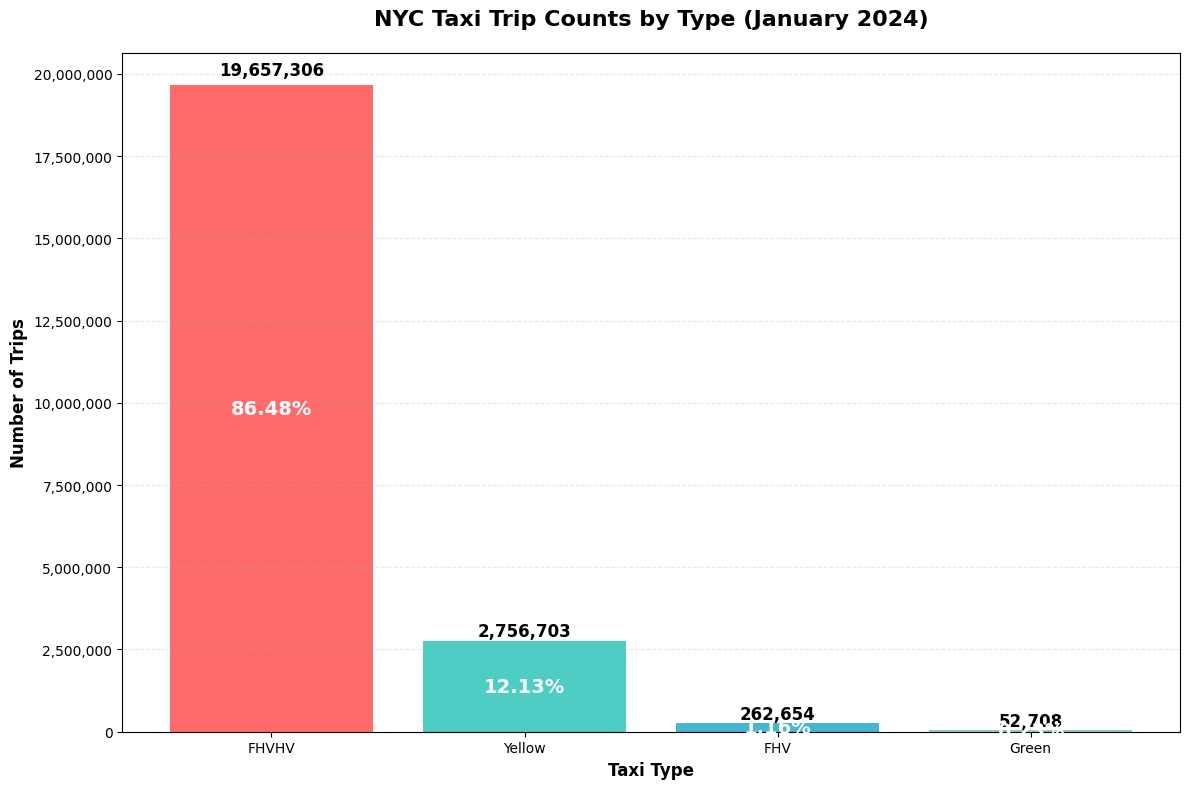


 Chart saved as 'trip_counts_bar_chart.png'


In [8]:
# Create bar chart
plt.figure(figsize=(12, 8))

# Define colors for each taxi type
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Create bar chart
bars = plt.bar(trip_counts['taxi_type'], trip_counts['trip_count'], color=colors[:len(trip_counts)])

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    # Trip count on top
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', 
             fontweight='bold', fontsize=12)
    # Percentage in middle
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{trip_counts.iloc[i]["percentage"]}%', ha='center', va='center',
             color='white', fontweight='bold', fontsize=14)

plt.title('NYC Taxi Trip Counts by Type (January 2024)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Taxi Type', fontsize=12, fontweight='bold')
plt.ylabel('Number of Trips', fontsize=12, fontweight='bold')

# Format y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add grid
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('trip_counts_bar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Chart saved as 'trip_counts_bar_chart.png'")

## 7. Visualization using Pie Chart

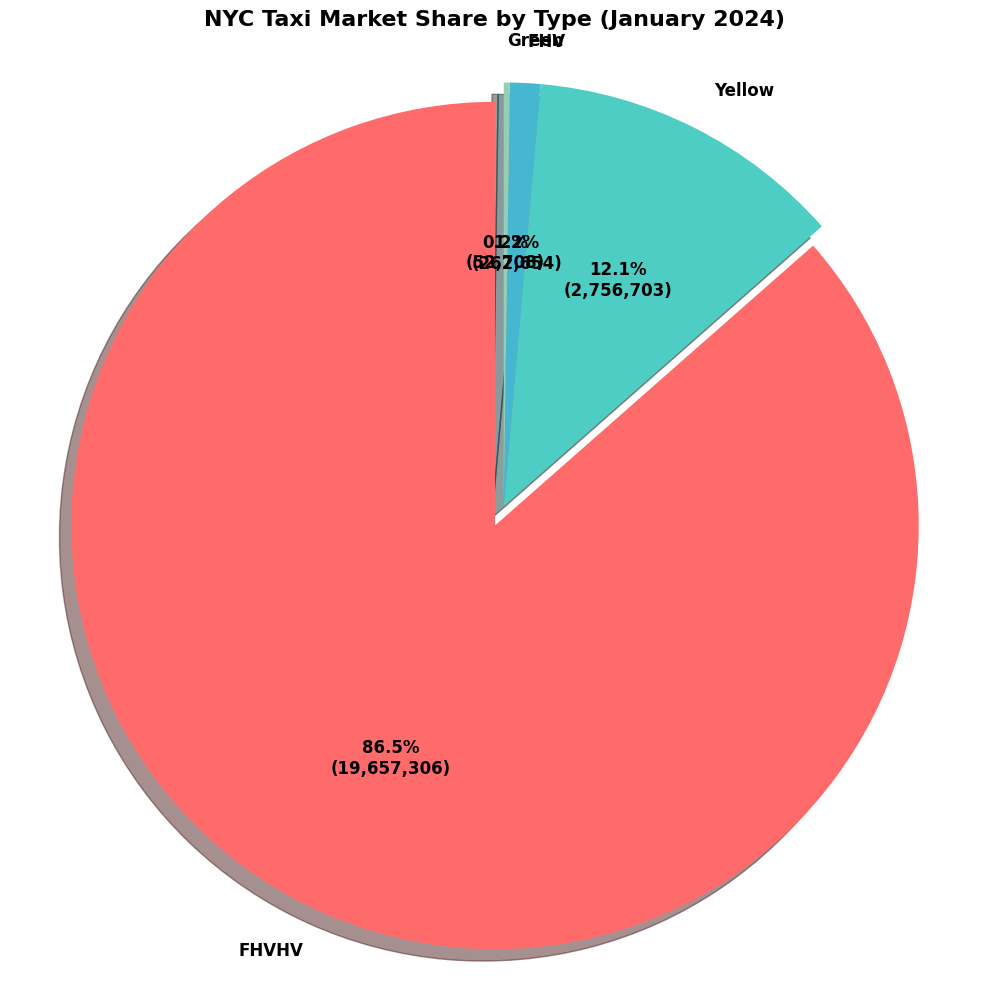


 Chart saved as 'trip_counts_pie_chart.png'


In [9]:
# Create pie chart
plt.figure(figsize=(10, 10))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
explode = [0.05 if i == 0 else 0 for i in range(len(trip_counts))]  # Explode top slice

plt.pie(trip_counts['trip_count'], 
        labels=trip_counts['taxi_type'],
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_trips):,})',
        colors=colors[:len(trip_counts)],
        explode=explode,
        shadow=True,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'})

plt.title('NYC Taxi Market Share by Type (January 2024)', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.savefig('trip_counts_pie_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Chart saved as 'trip_counts_pie_chart.png'")

## 8. Additional Analysis. Trips by Hour

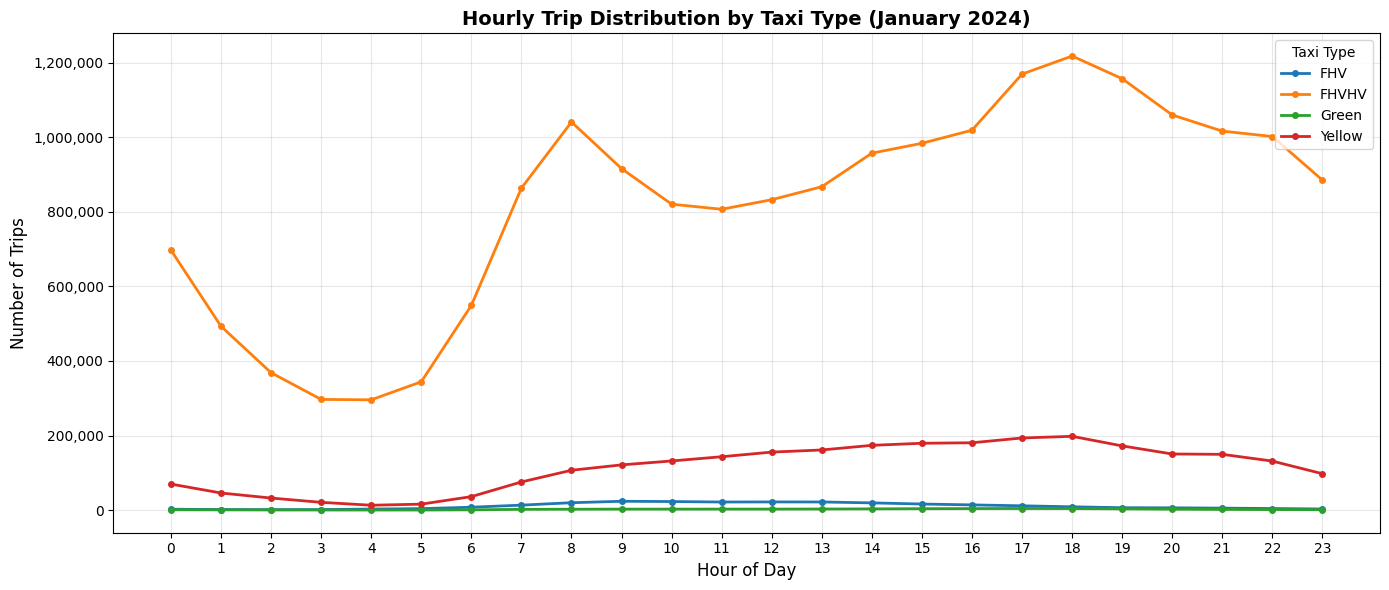

In [10]:
# Trips by hour of day
query = f"""
SELECT 
    HOUR(pickup_datetime) as hour_of_day,
    taxi_type,
    COUNT(*) as trip_count
FROM {DATABASE}.taxi_merged
GROUP BY HOUR(pickup_datetime), taxi_type
ORDER BY hour_of_day, taxi_type
"""

hourly_df = pd.read_sql(query, conn)

# Pivot for visualization
hourly_pivot = hourly_df.pivot(index='hour_of_day', columns='taxi_type', values='trip_count').fillna(0)

# Plot
plt.figure(figsize=(14, 6))
hourly_pivot.plot(kind='line', marker='o', linewidth=2, markersize=4, ax=plt.gca())
plt.title('Hourly Trip Distribution by Taxi Type (January 2024)', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(range(0, 24))
plt.legend(title='Taxi Type', loc='upper right')
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.savefig('hourly_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Final Summary Report

In [11]:
print("\n" + "=" * 80)
print("FINAL ANALYSIS REPORT - NYC TAXI DATA (JANUARY 2024)")
print("=" * 80)
print(f"\n Dataset Information:")
print(f"   • Data Source: NYC TLC Trip Record Data")
print(f"   • Analysis Period: January 1-31, 2024")
print(f"   • Total Records: {total_trips:,}")
print(f"   • Number of Taxi Types: {len(trip_counts)}")

print(f"\n Data Pipeline:")
print(f"   • Storage: Amazon S3")
print(f"   • ETL: AWS Glue")
print(f"   • Orchestration: AWS Step Functions")
print(f"   • Query Engine: Amazon Athena")
print(f"   • Analytics: Amazon SageMaker")

print(f"\n COMPLETE RANKING:")
print("-" * 60)
for _, row in trip_counts.iterrows():
    print(f"   {int(row['rank'])}. {row['taxi_type']}: {int(row['trip_count']):,} trips ({row['percentage']}%)")

print(f"\n" + "=" * 80)
print(f" ANSWER: Top Taxi Type = {top_type} with {top_count:,} rides ({top_pct}%)")
print("=" * 80)


FINAL ANALYSIS REPORT - NYC TAXI DATA (JANUARY 2024)

 Dataset Information:
   • Data Source: NYC TLC Trip Record Data
   • Analysis Period: January 1-31, 2024
   • Total Records: 22,729,371
   • Number of Taxi Types: 4

 Data Pipeline:
   • Storage: Amazon S3
   • ETL: AWS Glue
   • Orchestration: AWS Step Functions
   • Query Engine: Amazon Athena
   • Analytics: Amazon SageMaker

 COMPLETE RANKING:
------------------------------------------------------------
   1. FHVHV: 19,657,306 trips (86.48%)
   2. Yellow: 2,756,703 trips (12.13%)
   3. FHV: 262,654 trips (1.16%)
   4. Green: 52,708 trips (0.23%)

 ANSWER: Top Taxi Type = FHVHV with 19,657,306 rides (86.48%)


In [12]:
# Close connection
conn.close()
print("\nConnection closed.")


Connection closed.
